## Multisource Model M2 - OpenFWI Unsupervised Framework Implementation (FlatVel)

In [4]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import deepwave

from pysit.gallery import marmousi
from pysit.gallery import marmousi2

import numpy as np
import torch
import torch.optim
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models.vgg as vgg
from torch.autograd import Variable
from torch.optim.lr_scheduler import ExponentialLR

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from model import *

import seaborn as sns

from torchmetrics.functional import mean_absolute_error, mean_absolute_percentage_error, mean_squared_log_error

from tqdm.notebook import tqdm
from tqdm import tqdm

import scipy.ndimage

GPU = True
if GPU == True:
    torch.cuda.set_device(2)
    dtype = torch.cuda.FloatTensor
    device = torch.device('cuda:2')  
    torch.cuda.empty_cache()
    print("Total number of GPU available -",torch.cuda.device_count())
else:
    dtype = torch.FloatTensor

Total number of GPU available - 8


/home/naveengupta/.local/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 4.0.0-unsupported is an invalid version and will not be supported in a future release
  warnings.warn(


# Loading Data: OpenFWI

In [3]:
amp1 = np.load('FlatVel-A/amplitude/data1.npy')
amp2 = np.load('FlatVel-A/amplitude/data2.npy')

vel1 = np.load('FlatVel-A/velocity/model1.npy')
vel2 = np.load('FlatVel-A/velocity/model2.npy')


# converting to torch tensor
amp1 = torch.tensor(amp1, device=device)
amp2 = torch.tensor(amp2, device=device)

vel1 = torch.tensor(vel1, device=device)
vel2 = torch.tensor(vel2, device=device)

total_amp_data = torch.cat((amp1, amp2), 0)
total_vel_data = torch.cat((vel1, vel2), 0)

In [4]:
# Custom Dataloader for autoencoders for enumerating using PyTorch dataloader
class AutoEncoderDataLoader(Dataset):

    def __init__(self, amps):
        self.amps = amps

    def __getitem__(self, index):
        return self.amps[index]
    
    def __len__(self):
        return len(self.amps)

In [5]:
amp_data = AutoEncoderDataLoader(total_amp_data)

train_size = int(len(amp_data)*0.8)
test_size = len(amp_data) - train_size

train_data, test_data = torch.utils.data.random_split(amp_data, [train_size, test_size])

trainloader = DataLoader(train_data, batch_size=25, shuffle=True)
testloader = DataLoader(test_data, batch_size=25, shuffle=False)

### Loading InversionNet Trained Model

In [11]:
input_channels = 5
encoder_channels = [32, 64, 64, 64, 64, 128, 128, 128, 128,
                   256, 256, 256, 256, 512]

decoder_channels = [512, 256, 128, 64, 32]

# checkpoint = torch.load('Checkpoints/CurveVel-A/InversionNet_optimizer_epoch_loss.pth')

net = InversionNetB(input_channels, encoder_channels, decoder_channels).to(device)
# net.load_state_dict(torch.load('./Checkpoints/CurveVel-A/CurveVel-A_l_MSE_e_2000_no_parallel.pth'))
net.load_state_dict(torch.load('./Checkpoints/FlatVel-A/InversionNet_FlatVel_e_2000_weights.pth'))

# net.load_state_dict(checkpoint['model_state_dict'])

net.train()

InversionNetB(
  (conv_block_last): Sequential(
    (0): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (encoder_layers): Sequential(
    (0): Sequential(
      (0): Conv2d(5, 32, kernel_size=(7, 1), stride=(2, 1), padding=(3, 0))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 1), stride=(2, 1), padding=(1, 0))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.

In [9]:
params = [p for p in net.parameters()]

l2_loss = torch.nn.MSELoss()
l1_loss = torch.nn.L1Loss()

c = 1
# c = 0.3
# 
optimizer = torch.optim.SGD([{'params':params, 'lr':1e-4}])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

### Seismic Acquisition Parameters

In [10]:
## Numbers are referred from the OpenFWI paper (OpenFWI: Large-Scale Multi-Structural Benchmark 
## Datasets for Seismic Full Waveform Inversion)

dx = 10
nz, ny = 70, 70

num_dims = 2
num_shots = 5

num_sources_per_shot = 1
source_spacing = 140

num_receivers_per_shot = 70
receiver_spacing = 10

peak_freq = 15
dt = 0.001 # 4ms

n_seconds = 1   # number of seconds receivers are recording
nt = int(n_seconds / dt) # number of time samples

In [11]:
# Create arrays containing the source and receiver locations
# x_s: Source locations [num_shots, num_sources_per_shot, num_dimensions]
x_s = torch.zeros(num_shots, num_sources_per_shot, num_dims)
x_s[:, 0, 1] = torch.arange(num_shots).float() * source_spacing

# x_r: Receiver locations [num_shots, num_receivers_per_shot, num_dimensions]
x_r = torch.zeros(num_shots, num_receivers_per_shot, num_dims)
x_r[0, :, 1] = torch.arange(num_receivers_per_shot).float() * receiver_spacing
x_r[:, :, 1] = x_r[0, :, 1].repeat(num_shots, 1)

# Create true source amplitudes [nt, num_shots, num_sources_per_shot]
# I use Deepwave's Ricker wavelet function. The result is a normal Tensor - you
# can use whatever Tensor you want as the source amplitude.
source_amplitudes_true = (deepwave.wavelets.ricker(peak_freq, nt, dt, 1/peak_freq)
                          .reshape(-1, 1, 1)
                          .repeat(1, num_shots, num_sources_per_shot))

In [12]:
# Create initial guess source amplitude for inversion
# I will assume that the true source amplitude is the same for every shot
# so I will just create one source amplitude, and PyTorch will backpropagate
# updates to it from every shot
# This initial guess is shifted in frequency from the true one
source_amplitudes_init = (deepwave.wavelets.ricker(peak_freq, nt, dt, 1/peak_freq)
                          .reshape(-1, 1, 1))
source_amplitudes = source_amplitudes_init.clone()
source_amplitudes = source_amplitudes.to(device)


In [10]:
# Model fine-tuning

from torch.autograd import Variable

epochs = 1000
loss_curve = []

batch_amp_pred = torch.zeros((1000, 5, 70)).to(device)


for epoch in tqdm(range(epochs)):
    train_loss = 0
    for _, amp in enumerate(trainloader):
        optimizer.zero_grad()
        # amp = (amp - min_amp) / (max_amp - min_amp)
        amp = amp.to(device)
        vel_pred = net(amp)
        
        for i in range(25):
            vel = vel_pred[i].squeeze()
            prop = deepwave.scalar.Propagator({'vp': vel}, dx)
            # print(vel)
            batch_amp_pred = prop(source_amplitudes_true.to(device),
                                    x_s.to(device),
                                    x_r.to(device), 
                                    dt)
        
            batch_amp_pred = batch_amp_pred.permute(1, 0, 2)
            # loss1 = l1_loss(amp[i], batch_amp_pred)
            # loss2 = l2_loss(amp[i], batch_amp_pred)
            
            # pixel_loss = c * loss1 + (1-c) * loss2
            # amp = (max_amp - min_amp) * amp + min_amp 
            
            loss1 = l2_loss(amp[i], batch_amp_pred)
            # train_loss += pixel_loss.item()
            train_loss += loss1.item()

        loss1.backward()
        # pixel_loss.backward()
        optimizer.step()
    
    train_loss /= len(trainloader)
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}/{epochs}, Total Loss: {train_loss}")
    loss_curve.append(train_loss)
    
# t_end = time.time()

  0%|                                        | 1/1000 [00:24<6:40:05, 24.03s/it]

Epoch: 0/1000, Total Loss: 98.91157637536526


  1%|▍                                      | 11/1000 [04:36<6:57:55, 25.35s/it]

Epoch: 10/1000, Total Loss: 98.70734810084105


  2%|▊                                      | 21/1000 [08:52<6:53:16, 25.33s/it]

Epoch: 20/1000, Total Loss: 98.68578734993935


  3%|█▏                                     | 31/1000 [13:03<6:35:59, 24.52s/it]

Epoch: 30/1000, Total Loss: 98.1924998909235


  4%|█▌                                     | 41/1000 [17:01<5:48:29, 21.80s/it]

Epoch: 40/1000, Total Loss: 98.40796349942684


  5%|█▉                                     | 51/1000 [20:14<5:04:33, 19.26s/it]

Epoch: 50/1000, Total Loss: 98.85790511220694


  6%|██▍                                    | 61/1000 [23:26<4:59:42, 19.15s/it]

Epoch: 60/1000, Total Loss: 98.59562210738659


  7%|██▊                                    | 71/1000 [26:37<4:56:00, 19.12s/it]

Epoch: 70/1000, Total Loss: 98.38874465227127


  8%|███▏                                   | 81/1000 [29:48<4:53:02, 19.13s/it]

Epoch: 80/1000, Total Loss: 98.542301222682


  9%|███▌                                   | 91/1000 [33:00<4:50:39, 19.19s/it]

Epoch: 90/1000, Total Loss: 98.52025844156742


 10%|███▊                                  | 101/1000 [36:13<4:47:46, 19.21s/it]

Epoch: 100/1000, Total Loss: 98.31860528886318


 11%|████▏                                 | 111/1000 [39:26<4:46:20, 19.33s/it]

Epoch: 110/1000, Total Loss: 98.4553233385086


 12%|████▌                                 | 121/1000 [42:38<4:44:03, 19.39s/it]

Epoch: 120/1000, Total Loss: 98.32019131630659


 13%|████▉                                 | 131/1000 [45:50<4:38:31, 19.23s/it]

Epoch: 130/1000, Total Loss: 98.65023830533028


 14%|█████▎                                | 141/1000 [49:01<4:33:07, 19.08s/it]

Epoch: 140/1000, Total Loss: 98.44876351207495


 15%|█████▋                                | 151/1000 [52:13<4:30:42, 19.13s/it]

Epoch: 150/1000, Total Loss: 98.52785723656416


 16%|██████                                | 161/1000 [55:25<4:27:47, 19.15s/it]

Epoch: 160/1000, Total Loss: 98.14355625212193


 17%|██████▍                               | 171/1000 [58:37<4:26:11, 19.27s/it]

Epoch: 170/1000, Total Loss: 98.35964043438435


 18%|██████▌                             | 181/1000 [1:01:51<4:23:41, 19.32s/it]

Epoch: 180/1000, Total Loss: 98.27262469381094


 19%|██████▉                             | 191/1000 [1:05:04<4:19:35, 19.25s/it]

Epoch: 190/1000, Total Loss: 97.82383219897747


 20%|███████▏                            | 201/1000 [1:08:16<4:15:44, 19.20s/it]

Epoch: 200/1000, Total Loss: 98.39085028320551


 21%|███████▌                            | 211/1000 [1:11:28<4:11:28, 19.12s/it]

Epoch: 210/1000, Total Loss: 98.30257430672646


 22%|███████▉                            | 221/1000 [1:14:40<4:10:22, 19.28s/it]

Epoch: 220/1000, Total Loss: 97.9949953854084


 23%|████████▎                           | 231/1000 [1:17:52<4:06:12, 19.21s/it]

Epoch: 230/1000, Total Loss: 98.49906906485558


 24%|████████▋                           | 241/1000 [1:21:02<4:01:53, 19.12s/it]

Epoch: 240/1000, Total Loss: 98.24957817792892


 25%|█████████                           | 251/1000 [1:24:13<3:57:34, 19.03s/it]

Epoch: 250/1000, Total Loss: 97.80972219258547


 26%|█████████▍                          | 261/1000 [1:27:26<3:59:00, 19.41s/it]

Epoch: 260/1000, Total Loss: 98.17847982794046


 27%|█████████▊                          | 271/1000 [1:30:40<3:57:40, 19.56s/it]

Epoch: 270/1000, Total Loss: 97.93542016297579


 28%|██████████                          | 281/1000 [1:33:53<3:50:31, 19.24s/it]

Epoch: 280/1000, Total Loss: 97.82973027229309


 29%|██████████▍                         | 291/1000 [1:37:05<3:46:33, 19.17s/it]

Epoch: 290/1000, Total Loss: 98.03746966272593


 30%|██████████▊                         | 301/1000 [1:40:18<3:45:05, 19.32s/it]

Epoch: 300/1000, Total Loss: 98.16106179356575


 31%|███████████▏                        | 311/1000 [1:43:30<3:39:40, 19.13s/it]

Epoch: 310/1000, Total Loss: 97.91056920588017


 32%|███████████▌                        | 321/1000 [1:46:41<3:38:13, 19.28s/it]

Epoch: 320/1000, Total Loss: 98.12107958644629


 33%|███████████▉                        | 331/1000 [1:49:53<3:33:55, 19.19s/it]

Epoch: 330/1000, Total Loss: 97.65500073134899


 34%|████████████▎                       | 341/1000 [1:53:04<3:30:26, 19.16s/it]

Epoch: 340/1000, Total Loss: 98.06755619496107


 35%|████████████▋                       | 351/1000 [1:56:17<3:29:12, 19.34s/it]

Epoch: 350/1000, Total Loss: 98.24390442669392


 36%|████████████▉                       | 361/1000 [1:59:29<3:23:40, 19.12s/it]

Epoch: 360/1000, Total Loss: 97.64662182331085


 37%|█████████████▎                      | 371/1000 [2:02:40<3:20:08, 19.09s/it]

Epoch: 370/1000, Total Loss: 97.48633505403996


 38%|█████████████▋                      | 381/1000 [2:05:51<3:17:08, 19.11s/it]

Epoch: 380/1000, Total Loss: 97.62601074576378


 39%|██████████████                      | 391/1000 [2:09:04<3:16:47, 19.39s/it]

Epoch: 390/1000, Total Loss: 97.5643580853939


 40%|██████████████▍                     | 401/1000 [2:12:17<3:13:53, 19.42s/it]

Epoch: 400/1000, Total Loss: 97.20053701847792


 41%|██████████████▊                     | 411/1000 [2:15:30<3:09:38, 19.32s/it]

Epoch: 410/1000, Total Loss: 97.71059497445822


 42%|███████████████▏                    | 421/1000 [2:18:41<3:05:33, 19.23s/it]

Epoch: 420/1000, Total Loss: 97.66259828954935


 43%|███████████████▌                    | 431/1000 [2:21:53<3:01:44, 19.16s/it]

Epoch: 430/1000, Total Loss: 97.57782236486673


 44%|███████████████▉                    | 441/1000 [2:25:05<2:58:48, 19.19s/it]

Epoch: 440/1000, Total Loss: 97.84274868667126


 45%|████████████████▏                   | 451/1000 [2:28:17<2:55:40, 19.20s/it]

Epoch: 450/1000, Total Loss: 97.16920954734087


 46%|████████████████▌                   | 461/1000 [2:31:29<2:51:34, 19.10s/it]

Epoch: 460/1000, Total Loss: 97.3966001495719


 47%|████████████████▉                   | 471/1000 [2:34:41<2:49:23, 19.21s/it]

Epoch: 470/1000, Total Loss: 97.43522509932518


 48%|█████████████████▎                  | 481/1000 [2:37:54<2:48:04, 19.43s/it]

Epoch: 480/1000, Total Loss: 97.2544205635786


 49%|█████████████████▋                  | 491/1000 [2:41:06<2:43:45, 19.30s/it]

Epoch: 490/1000, Total Loss: 97.66476780921221


 50%|██████████████████                  | 501/1000 [2:44:19<2:41:25, 19.41s/it]

Epoch: 500/1000, Total Loss: 97.63415564596653


 51%|██████████████████▍                 | 511/1000 [2:47:32<2:37:11, 19.29s/it]

Epoch: 510/1000, Total Loss: 97.70147334039211


 52%|██████████████████▊                 | 521/1000 [2:50:44<2:33:05, 19.18s/it]

Epoch: 520/1000, Total Loss: 97.16159778833389


 53%|███████████████████                 | 531/1000 [2:53:55<2:30:04, 19.20s/it]

Epoch: 530/1000, Total Loss: 97.45672968029976


 54%|███████████████████▍                | 541/1000 [2:57:07<2:26:46, 19.19s/it]

Epoch: 540/1000, Total Loss: 97.45568089187145


 55%|███████████████████▊                | 551/1000 [3:00:19<2:23:35, 19.19s/it]

Epoch: 550/1000, Total Loss: 97.54352470487356


 56%|████████████████████▏               | 561/1000 [3:03:33<2:21:45, 19.37s/it]

Epoch: 560/1000, Total Loss: 97.58577723801136


 57%|████████████████████▌               | 571/1000 [3:06:46<2:17:13, 19.19s/it]

Epoch: 570/1000, Total Loss: 97.12026365846395


 58%|████████████████████▉               | 581/1000 [3:09:59<2:14:33, 19.27s/it]

Epoch: 580/1000, Total Loss: 97.76112181693316


 59%|█████████████████████▎              | 591/1000 [3:13:11<2:10:58, 19.21s/it]

Epoch: 590/1000, Total Loss: 97.40335457026958


 60%|█████████████████████▋              | 601/1000 [3:16:25<2:08:52, 19.38s/it]

Epoch: 600/1000, Total Loss: 97.25719586759806


 61%|█████████████████████▉              | 611/1000 [3:19:37<2:04:55, 19.27s/it]

Epoch: 610/1000, Total Loss: 97.22019722312689


 62%|██████████████████████▎             | 621/1000 [3:22:52<2:02:34, 19.40s/it]

Epoch: 620/1000, Total Loss: 97.32848316431046


 63%|██████████████████████▋             | 631/1000 [3:26:06<1:58:51, 19.33s/it]

Epoch: 630/1000, Total Loss: 97.13993793725967


 64%|███████████████████████             | 641/1000 [3:29:20<1:55:13, 19.26s/it]

Epoch: 640/1000, Total Loss: 97.08851195126772


 65%|███████████████████████▍            | 651/1000 [3:32:32<1:52:09, 19.28s/it]

Epoch: 650/1000, Total Loss: 97.3868640139699


 66%|███████████████████████▊            | 661/1000 [3:35:45<1:48:40, 19.23s/it]

Epoch: 660/1000, Total Loss: 97.22353949397802


 67%|████████████████████████▏           | 671/1000 [3:38:57<1:45:24, 19.22s/it]

Epoch: 670/1000, Total Loss: 97.27237670123577


 68%|████████████████████████▌           | 681/1000 [3:42:09<1:41:24, 19.08s/it]

Epoch: 680/1000, Total Loss: 96.94939556717873


 69%|████████████████████████▉           | 691/1000 [3:45:20<1:38:57, 19.22s/it]

Epoch: 690/1000, Total Loss: 96.80089156329632


 70%|█████████████████████████▏          | 701/1000 [3:48:32<1:35:28, 19.16s/it]

Epoch: 700/1000, Total Loss: 97.08660376816988


 71%|█████████████████████████▌          | 711/1000 [3:51:44<1:32:26, 19.19s/it]

Epoch: 710/1000, Total Loss: 96.91425870358944


 72%|█████████████████████████▉          | 721/1000 [3:54:55<1:28:59, 19.14s/it]

Epoch: 720/1000, Total Loss: 97.03069424629211


 73%|██████████████████████████▎         | 731/1000 [3:58:08<1:26:36, 19.32s/it]

Epoch: 730/1000, Total Loss: 96.94239212572575


 74%|██████████████████████████▋         | 741/1000 [4:01:21<1:23:48, 19.42s/it]

Epoch: 740/1000, Total Loss: 96.89090873301029


 75%|███████████████████████████         | 751/1000 [4:04:34<1:19:50, 19.24s/it]

Epoch: 750/1000, Total Loss: 96.59044536948204


 76%|███████████████████████████▍        | 761/1000 [4:07:48<1:18:38, 19.74s/it]

Epoch: 760/1000, Total Loss: 96.52504379302263


 77%|███████████████████████████▊        | 771/1000 [4:11:02<1:14:00, 19.39s/it]

Epoch: 770/1000, Total Loss: 96.70949599146843


 78%|████████████████████████████        | 781/1000 [4:14:15<1:10:23, 19.29s/it]

Epoch: 780/1000, Total Loss: 97.09546519070864


 79%|████████████████████████████▍       | 791/1000 [4:17:29<1:07:52, 19.49s/it]

Epoch: 790/1000, Total Loss: 96.91175557672977


 80%|████████████████████████████▊       | 801/1000 [4:20:42<1:04:10, 19.35s/it]

Epoch: 800/1000, Total Loss: 96.86944542080164


 81%|█████████████████████████████▏      | 811/1000 [4:23:56<1:01:02, 19.38s/it]

Epoch: 810/1000, Total Loss: 96.70683068037033


 82%|███████████████████████████████▏      | 821/1000 [4:27:07<57:17, 19.20s/it]

Epoch: 820/1000, Total Loss: 96.62731036543846


 83%|███████████████████████████████▌      | 831/1000 [4:30:21<54:17, 19.27s/it]

Epoch: 830/1000, Total Loss: 96.78732369095087


 84%|███████████████████████████████▉      | 841/1000 [4:33:36<51:35, 19.47s/it]

Epoch: 840/1000, Total Loss: 96.66415952146053


 85%|████████████████████████████████▎     | 851/1000 [4:36:48<47:52, 19.28s/it]

Epoch: 850/1000, Total Loss: 96.84532094746828


 86%|████████████████████████████████▋     | 861/1000 [4:40:01<44:36, 19.26s/it]

Epoch: 860/1000, Total Loss: 96.69128889590502


 87%|█████████████████████████████████     | 871/1000 [4:43:15<41:58, 19.53s/it]

Epoch: 870/1000, Total Loss: 96.55883023142815


 88%|█████████████████████████████████▍    | 881/1000 [4:46:28<38:25, 19.37s/it]

Epoch: 880/1000, Total Loss: 96.77384662628174


 89%|█████████████████████████████████▊    | 891/1000 [4:49:42<35:05, 19.32s/it]

Epoch: 890/1000, Total Loss: 96.59510438144207


 90%|██████████████████████████████████▏   | 901/1000 [4:52:55<31:53, 19.33s/it]

Epoch: 900/1000, Total Loss: 96.32232655584812


 91%|██████████████████████████████████▌   | 911/1000 [4:56:09<28:49, 19.43s/it]

Epoch: 910/1000, Total Loss: 96.53012985736132


 92%|██████████████████████████████████▉   | 921/1000 [4:59:21<25:27, 19.34s/it]

Epoch: 920/1000, Total Loss: 96.5111175775528


 93%|███████████████████████████████████▍  | 931/1000 [5:02:34<22:10, 19.29s/it]

Epoch: 930/1000, Total Loss: 96.5028221309185


 94%|███████████████████████████████████▊  | 941/1000 [5:05:46<18:55, 19.25s/it]

Epoch: 940/1000, Total Loss: 96.79418480396271


 95%|████████████████████████████████████▏ | 951/1000 [5:08:59<15:44, 19.27s/it]

Epoch: 950/1000, Total Loss: 96.4189542233944


 96%|████████████████████████████████████▌ | 961/1000 [5:12:11<12:30, 19.25s/it]

Epoch: 960/1000, Total Loss: 96.41023318469524


 97%|████████████████████████████████████▉ | 971/1000 [5:15:23<09:13, 19.10s/it]

Epoch: 970/1000, Total Loss: 96.31842243671417


 98%|█████████████████████████████████████▎| 981/1000 [5:18:37<06:05, 19.22s/it]

Epoch: 980/1000, Total Loss: 96.09147460758686


 99%|█████████████████████████████████████▋| 991/1000 [5:21:49<02:54, 19.37s/it]

Epoch: 990/1000, Total Loss: 96.5065433010459


100%|█████████████████████████████████████| 1000/1000 [5:24:44<00:00, 19.48s/it]


In [11]:
torch.save(net.state_dict(), 'Checkpoints/FlatVel-A/multisource/UPFWI_e_1000_SGD.pth')

In [12]:
torch.save({'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
           }, 'Checkpoints/FlatVel-A/multisource/UPFWI_e_1000_SGD_optimizer.pth')

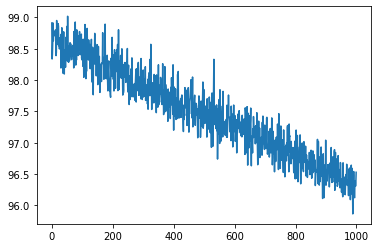

In [13]:
plt.plot(loss_curve)
plt.savefig("Checkpoints/FlatVel-A/multisource/UPFWI_e_1000.png")

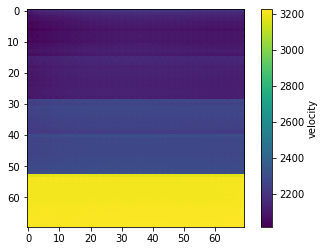

In [46]:
amp = total_amp_data[20:50]

pred_vel = net(amp)

# vel = vel[15,0,:]
first_vel = pred_vel[15,0,:]

vel_np = first_vel.detach().cpu().numpy()

plt.imshow(vel_np)
plt.colorbar(label='velocity')

plt.savefig("Checkpoints/FlatVel-A/multisource/UPFWI_e_1000_20_50_prediction.png")
plt.show()

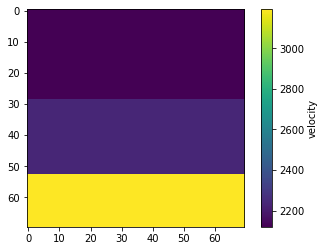

In [47]:
vel = total_vel_data[20:50]
vel = vel.detach().cpu().numpy()
plt.imshow(vel[15,0,:])
plt.colorbar(label='velocity')
plt.savefig("Checkpoints/FlatVel-A/multisource/UPFWI_20_50_true.png")
plt.show()

In [17]:
naive_model = InversionNetB(input_channels, encoder_channels, decoder_channels).to(device)
# net.load_state_dict(torch.load('./Checkpoints/FlatVel-A/FlatVel-A_l_MSE_e_2000_no_parallel.pth'))
naive_model.load_state_dict(torch.load('./Checkpoints/FlatVel-A/Copy_1_InversionNet_FlatVel_e_2000_weights-Copy1.pth'))
naive_model.eval()

InversionNetB(
  (conv_block_last): Sequential(
    (0): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (encoder_layers): Sequential(
    (0): Sequential(
      (0): Conv2d(5, 32, kernel_size=(7, 1), stride=(2, 1), padding=(3, 0))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 1), stride=(2, 1), padding=(1, 0))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.

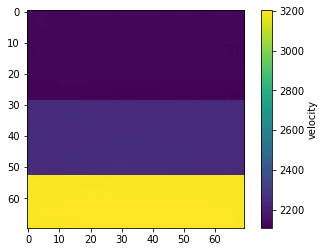

In [48]:
amp = total_amp_data[20:50]

pred_vel = naive_model(amp)

# vel = vel[15,0,:]
first_vel = pred_vel[15,0,:]

vel_np = first_vel.detach().cpu().numpy()

plt.imshow(vel_np)
plt.colorbar(label='velocity')

plt.savefig("Checkpoints/FlatVel-A/multisource/InversionNet_20_50_prediction.png")
plt.show()

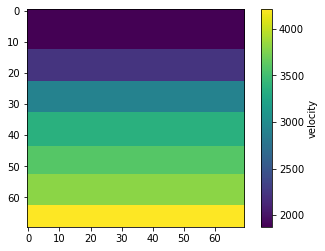

In [19]:
vel = total_vel_data[40:60]
vel = vel.detach().cpu().numpy()
plt.imshow(vel[15,0,:])
plt.colorbar(label='velocity')
# plt.savefig("Checkpoints/FlatVel-A/multisource/InversionNet_10_40_true.png")
plt.show()

## Loading model for inference

In [13]:
# Loading Model for Inference
model=InversionNetB(input_channels, encoder_channels, decoder_channels) #.type(dtype).to(device)
model.load_state_dict(torch.load('Checkpoints/FlatVel-A/multisource/Copy1_UPFWI_e_1000_SGD.pth'))
model.eval()

InversionNetB(
  (conv_block_last): Sequential(
    (0): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (encoder_layers): Sequential(
    (0): Sequential(
      (0): Conv2d(5, 32, kernel_size=(7, 1), stride=(2, 1), padding=(3, 0))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 1), stride=(2, 1), padding=(1, 0))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.

/tmp/ipykernel_53399/3029487606.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mae = mean_absolute_error(torch.tensor(pred_vel).to(device), torch.tensor(vel).to(device)).detach().cpu().numpy()
/tmp/ipykernel_53399/3029487606.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mre = mean_absolute_percentage_error(torch.tensor(pred_vel).to(device), torch.tensor(vel).to(device)).detach().cpu().numpy()


Mean Absolute Error (MAE):  22.185404
Mean Relative Error (MRE):  0.008742647

Prediction


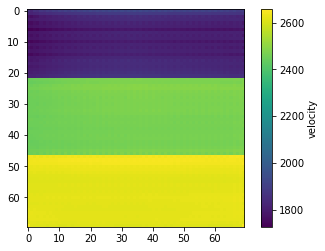

Ground Truth


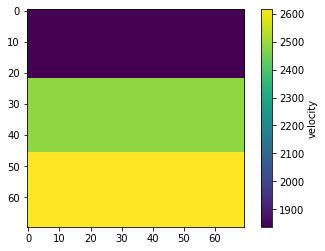

In [18]:
# Evaluation metrics - MAE and MRE
# with e=1000
amp = total_amp_data[0:]
vel = total_vel_data[0:]
pred_vel = model(amp.to('cpu'))

mae = mean_absolute_error(torch.tensor(pred_vel).to(device), torch.tensor(vel).to(device)).detach().cpu().numpy()
mre = mean_absolute_percentage_error(torch.tensor(pred_vel).to(device), torch.tensor(vel).to(device)).detach().cpu().numpy()
print("Mean Absolute Error (MAE): ", mae)
print("Mean Relative Error (MRE): ", mre)
print("")
vel = vel[15,0,:]
pred_vel = pred_vel[15,0,:]

print("Prediction")
pred_vel = pred_vel.detach().cpu().numpy()
plt.imshow(pred_vel)
plt.colorbar(label='velocity')
plt.show()

print("Ground Truth")
true_vel = vel.detach().cpu().numpy()
plt.imshow(true_vel)
plt.colorbar(label='velocity')
plt.show()

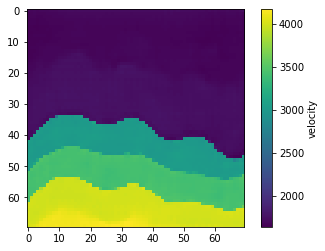

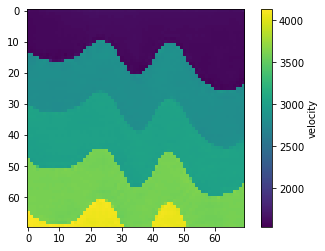

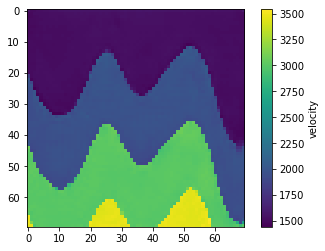

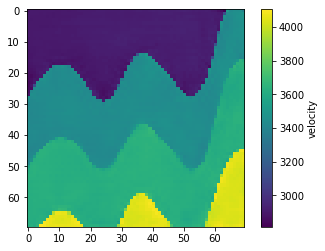

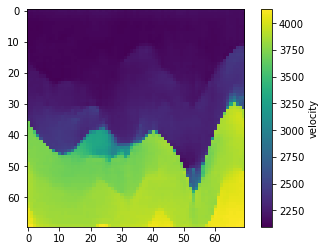

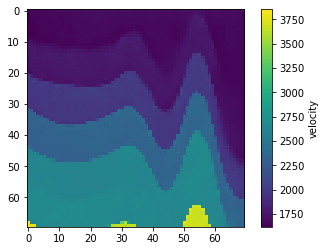

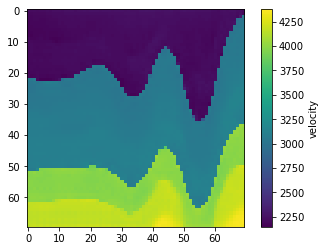

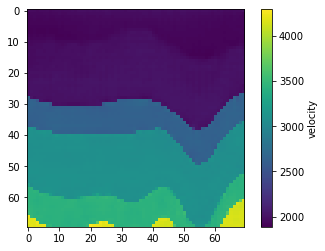

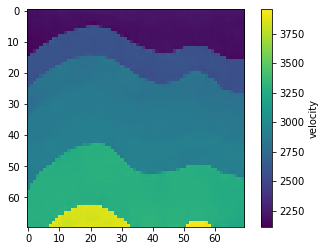

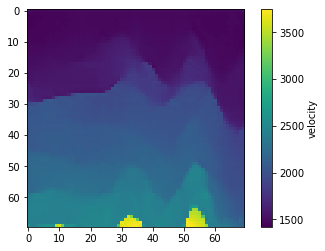

In [12]:
pred_amp= total_amp_data[0:50]

pred_vel = net(pred_amp)

# vel = vel[15,0,:]
for i in range(10):
    first_vel = pred_vel[i,0,:]

    vel_np = first_vel.detach().cpu().numpy()

    plt.imshow(vel_np)
    plt.colorbar(label='velocity')
    plt.show()

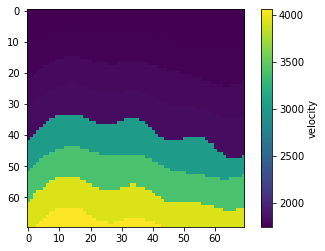

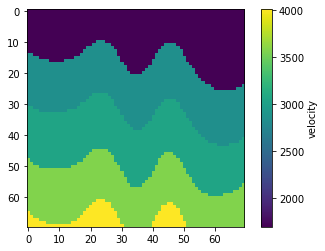

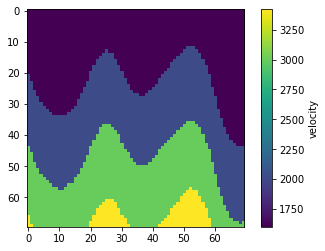

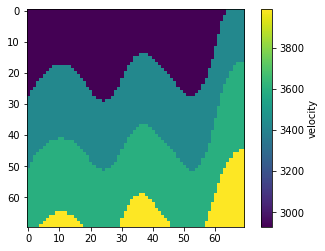

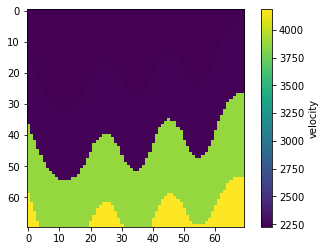

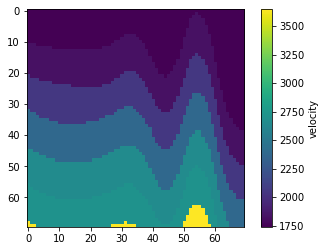

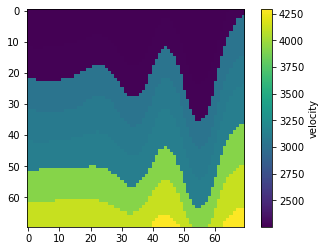

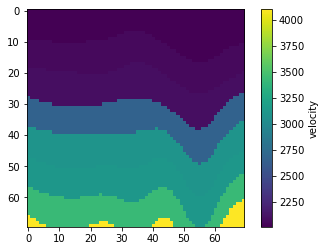

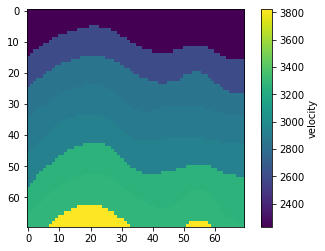

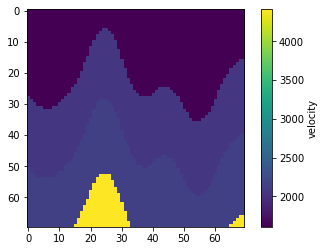

In [13]:
vel_true = total_vel_data[0:10]

for i in range(10):
    first_vel = vel_true[i,0,:]

    vel_np = first_vel.detach().cpu().numpy()

    plt.imshow(vel_np)
    plt.colorbar(label='velocity')
    plt.show()

## Multisource model M2 on Marmousi Data

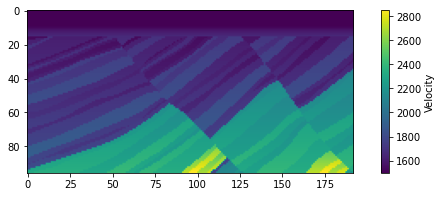

In [5]:
# Loading marmousi data
vp_true, vp_init, m, d = marmousi2(origin=(7500, 355), 
                        size=(1910, 950), 
                        pixel_scale="small",
                        initial_model_style="gradient",
                        initial_config={'min':1500.0,'max':3000.0})

# To load full model
# vp_true, vp_init, m, d = marmousi2(patch='mini_square',pixel_scale='mini')


plot_shape = m.shape(as_grid=True)
vp_true_np = vp_true.reshape(plot_shape).T
# vp_init_np = vp_init.reshape(plot_shape).T

fig1 = plt.figure(figsize=(10,3))

# Used when full marmousi model is taken at pixel_scale = mini
# vp_true = np.pad(vp_true, ((40,40),(86,87)), mode = 'reflect')
# vp_init = np.pad(vp_init, ((40,40),(86,87)), mode = 'reflect')

#Changing to tensor
vp_true_var = torch.tensor(vp_true_np)
model_true = vp_true_var.clone().to(device)
model_true_var = model_true[None,None,...].type(dtype)
model_true_var = model_true_var.to(device)

vmin_true = torch.min(model_true_var)
vmax_true = torch.max(model_true_var)

vp_init_np = scipy.ndimage.gaussian_filter(model_true_var.cpu().detach().numpy(),
                                           sigma=15).squeeze()

#model_true_var = (model_true_var - vmin_true)/(vmax_true - vmin_true)

plt.imshow(model_true_var.detach().cpu().numpy().squeeze())
plt.colorbar(label='Velocity')
#plt.clim(1000,3000)

vp_init = torch.tensor(vp_init_np)
model_init = vp_init.clone()

In [7]:
# Model setup for DeepWave
dx = m.deltas[0]
nz, ny = vp_true_np.shape
num_dims = 2

# acquisition setup
num_shots = 20

num_sources_per_shot = 1
source_spacing = ny*dx / num_shots #10.0

num_receivers_per_shot = 96
receiver_spacing = ny*dx / num_receivers_per_shot #10.0

peak_freq = 10
dt = 0.004 # 4ms

n_seconds = 4
nt = int(n_seconds / dt)

In [8]:
#Build acquisition data

# Create arrays containing the source and receiver locations
# x_s: Source locations [num_shots, num_sources_per_shot, num_dimensions]
x_s = torch.zeros(num_shots, num_sources_per_shot, num_dims)
x_s[:, 0, 1] = torch.arange(num_shots).float() * source_spacing

# x_r: Receiver locations [num_shots, num_receivers_per_shot, num_dimensions]
x_r = torch.zeros(num_shots, num_receivers_per_shot, num_dims)
x_r[0, :, 1] = torch.arange(num_receivers_per_shot).float() * receiver_spacing
x_r[:, :, 1] = x_r[0, :, 1].repeat(num_shots, 1)

# Create true source amplitudes [nt, num_shots, num_sources_per_shot]
# I use Deepwave's Ricker wavelet function. The result is a normal Tensor - you
# can use whatever Tensor you want as the source amplitude.
source_amplitudes_true = (deepwave.wavelets.ricker(peak_freq, nt, dt, 1/peak_freq)
                          .reshape(-1, 1, 1)
                          .repeat(1, num_shots, num_sources_per_shot))

In [9]:
prop = deepwave.scalar.Propagator({'vp': model_true.to(device)}, dx)
receiver_amplitudes_true = prop(source_amplitudes_true.to(device),
                                x_s.to(device),
                                x_r.to(device), 
                                dt).cpu()

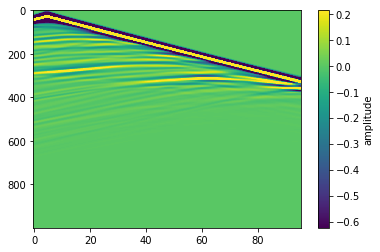

In [14]:
# Plot one shot gather
vmin, vmax = np.percentile(receiver_amplitudes_true[:,1].cpu().numpy(), [2,98])
plt.imshow(receiver_amplitudes_true[:,1].cpu().numpy(), aspect='auto',
           vmin=vmin, vmax=vmax)
plt.colorbar(label='amplitude')

In [12]:
# Loading Model for Inference
model=InversionNetB(input_channels, encoder_channels, decoder_channels) #.type(dtype).to(device)
model.load_state_dict(torch.load('Checkpoints/FlatVel-A/multisource/Copy1_UPFWI_e_1000_SGD.pth'))
model.eval()

InversionNetB(
  (conv_block_last): Sequential(
    (0): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (encoder_layers): Sequential(
    (0): Sequential(
      (0): Conv2d(5, 32, kernel_size=(7, 1), stride=(2, 1), padding=(3, 0))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 1), stride=(2, 1), padding=(1, 0))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.

In [25]:
receiver_amplitudes_true[:32,:5,:7].shape

torch.Size([32, 5, 7])

In [27]:
receiver_amplitudes_true = receiver_amplitudes_true.permute(1,0,2)
receiver_amplitudes_true.shape

torch.Size([20, 1000, 96])

In [30]:
receiver_amplitudes_true[:5,:].shape

torch.Size([5, 1000, 96])

Prediction


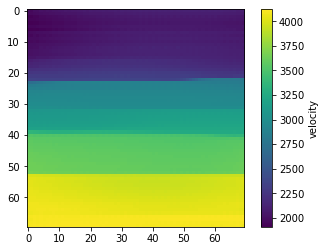

Ground Truth


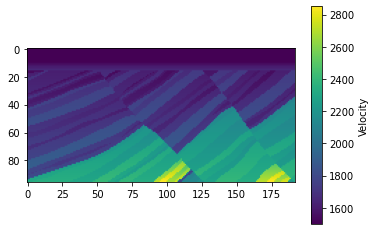

In [34]:
pred_vel = model(receiver_amplitudes_true[None,0:5,:, 0:70])

print("Prediction")
pred_vel = pred_vel.detach().cpu().numpy().squeeze()
plt.imshow(pred_vel)
plt.colorbar(label='velocity')
plt.show()

print("Ground Truth")
plt.imshow(model_true_var.detach().cpu().numpy().squeeze())
plt.colorbar(label='Velocity')

In [41]:
model_true_var = model_true_var.squeeze()
model_true_var = model_true_var[:70,:70]
mae = mean_absolute_error(torch.tensor(pred_vel).to(device), torch.tensor(model_true_var).to(device)).detach().cpu().numpy()
mre = mean_absolute_percentage_error(torch.tensor(pred_vel).to(device), torch.tensor(model_true_var).to(device)).detach().cpu().numpy()
print("Mean Absolute Error (MAE): ", mae)
print("Mean Relative Error (MRE): ", mre)

Mean Absolute Error (MAE):  1416.3877
Mean Relative Error (MRE):  0.83757126


/tmp/ipykernel_56411/4036193918.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mae = mean_absolute_error(torch.tensor(pred_vel).to(device), torch.tensor(model_true_var).to(device)).detach().cpu().numpy()
/tmp/ipykernel_56411/4036193918.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mre = mean_absolute_percentage_error(torch.tensor(pred_vel).to(device), torch.tensor(model_true_var).to(device)).detach().cpu().numpy()
